# Exploration of Linux dataset

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from interank.plotting import sigconf_settings
import matplotlib.patches as patches

DATA_DIR = '/data/datasets/linux/'

## Load dataset

In [2]:
print('Loading data...')
df = pd.read_csv(DATA_DIR + 'data.csv')
print('Loaded {} patches.'.format(len(df)))
print('Proportion accepted: {:.2f}%'.format(df['accepted'].mean() * 100))

Loading data...
Loaded 619419 patches.
Proportion accepted: 34.12%


### Useful columns

In [3]:
df[['patch_id', 'name', 'company', 'subsystem', 'accepted', ]].head()

,patch_id,name,company,subsystem,accepted
0,linuxnext-lkml_349165_4,arjan@infradead.org,infradead,include/linux,1
1,linuxnext-lkml_349504_0,jfannin@gmail.com,rivenstone,drivers/char,0
2,linuxnext-lkml_349319_1,airlied@linux.ie,linux,drivers/char,0
3,linuxnext-lkml_349539_0,tali@admingilde.org,admingilde,scripts,0
4,linuxnext-lkml_349587_0,drzeus@drzeus.cx,drzeus,drivers/mmc,0


## CCDF of patches per user

All users have at least one patch. Only 1% of users have published more than 1000 patches.

There are 9672 different users.
Top-ten most active users:
  torvalds@linux-foundation.org : 73545
  greg@echidna.(none)           : 12539
  akpm@linux-foundation.org     : 12377
  tj@kernel.org                 : 6047
  yhlu.kernel@gmail.com         : 4666
  rostedt@goodmis.org           : 4270
  a.p.zijlstra@chello.nl        : 4178
  mingo@elte.hu                 : 4059
  ak@muc.de                     : 3826
  bywayofJesseBarnesjbarnes@virtuousgeek.org: 3539


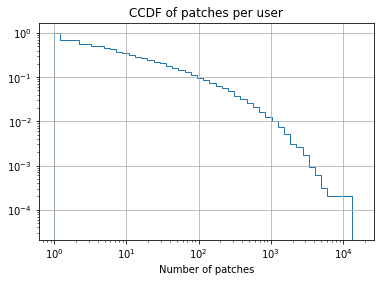

In [4]:
# Extract patches per user
users = df['name'].value_counts()
print('There are {} different users.'.format(users.count()))
print('Top-ten most active users:')
for s, count in users[:10].iteritems():
    print('  {:<30}: {}'.format(s, count))

# Plot
users.hist(bins=np.logspace(0, 14, 50, base=2), cumulative=-1, normed=True, log=True, histtype="step")
plt.gca().set_xscale("log")
plt.xlabel("Number of patches")
plt.title("CCDF of patches per user")
plt.show()

## CCDF of patches per subsystem

There are 394 different subystems.
Top-ten most patched subsystems:
  drivers/net         : 53099
  arch/arm            : 51467
  include/linux       : 37653
  arch/x86            : 32998
  kernel              : 32507
  mm                  : 26168
  drivers/staging     : 23930
  drivers/usb         : 20093
  drivers/scsi        : 16924
  drivers/media       : 12521


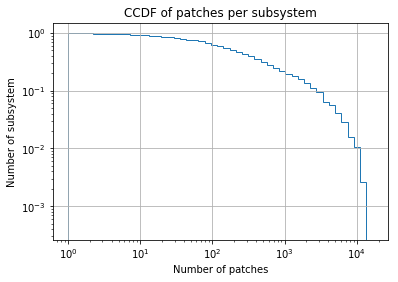

In [5]:
# Extract patches per subsystem
subsystems = df[(df['subsystem'] != 'N/A') & (df['subsystem'] != '')]['subsystem'].value_counts()
print('There are {} different subystems.'.format(subsystems.count()))
print('Top-ten most patched subsystems:')
for s, count in subsystems[:10].iteritems():
    print('  {:<20}: {}'.format(s, count))

# Plot
subsystems.hist(bins=np.logspace(0, 14, 50, base=2), cumulative=-1, normed=True, log=True, histtype='step')
plt.title('CCDF of patches per subsystem')
plt.xlabel('Number of patches')
plt.ylabel('Number of subsystem')
plt.xscale('log')

## CCDF of subsystems per user

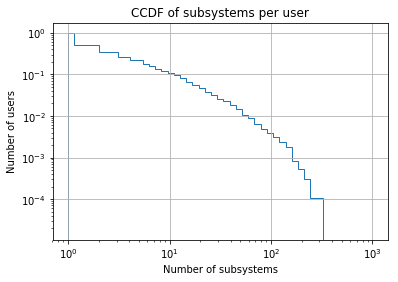

In [6]:
# Count user contributions to subsystems
contributions = defaultdict(Counter)
for row in df[['name', 'subsystem', 'accepted']].itertuples():
#     if row.accepted == 1:
    contributions[row.name][row.subsystem] += 1

# Plot
num_subsystems = [len(subsystems) for _, subsystems in contributions.items()]
plt.hist(num_subsystems, cumulative=-1, histtype='step', bins=np.logspace(0, 3, 50), log=True, normed=True)
plt.title('CCDF of subsystems per user')
plt.xlabel('Number of subsystems')
plt.ylabel('Number of users')
plt.xscale('log')
plt.grid()
plt.show()

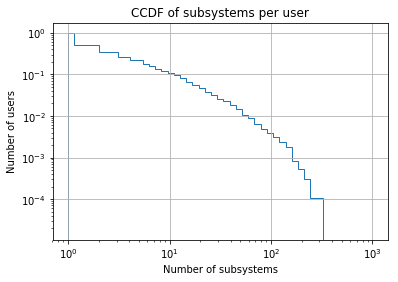

In [7]:
# Count user contributions to subsystems
contributions = defaultdict(Counter)
for row in df[['name', 'subsystem', 'accepted']].itertuples():
#     if row.accepted == 1:
    contributions[row.name][row.subsystem] += 1

# Plot
num_subsystems = [len(subsystems) for _, subsystems in contributions.items()]
plt.hist(num_subsystems, cumulative=-1, histtype='step', bins=np.logspace(0, 3, 50), log=True, normed=True)
plt.title('CCDF of subsystems per user')
plt.xlabel('Number of subsystems')
plt.ylabel('Number of users')
plt.xscale('log')
plt.grid()
plt.show()

## CCDF of side-subsystem

A "side-subsystem" is all the subsystems without the one a user has contributed the most to.

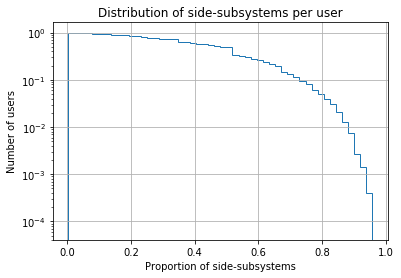

In [8]:
def count(counter):
    return sum(counter.values())

def proportion_side_subsystems(all_subsystems):
    n = len(all_subsystems) - 1
    side_subsystems = [c for _, c in all_subsystems.most_common()[:-n-1:-1]]
    return sum(side_subsystems) / count(all_subsystems)
    

# Count proportion of user contribution to side-subsystems
side_subsystems = [proportion_side_subsystems(c) for _, c in contributions.items()]
side_subsystems = [p for p in side_subsystems if p > 0]

# Plot
plt.hist(side_subsystems, cumulative=-1, histtype='step', bins=50, log=True, normed=True)
plt.title('Distribution of side-subsystems per user')
plt.xlabel('Proportion of side-subsystems')
plt.ylabel('Number of users')
plt.grid()
plt.show()

## Co-patching correlation matrix

In [9]:
# Keep mappings between objects and indices
idx2subsystem = list(subsystems.keys())
subsystem2idx = {k: i for i, k in enumerate(idx2subsystem)}
idx2user = list(contributions.keys())
user2idx = {k: i for i, k in enumerate(idx2user)}

# Extract cluster (main subsystem) for each user
main_subsystem = [c.most_common(1)[0][0] for _, c in contributions.items()]
useridx2cluster = [subsystem2idx[s] for s in main_subsystem]

# Number of users
N = len(contributions)
# Number of subsystems
M = len(subsystems)

# Extract contribution vector for each cluster (subsystem)
X_clustered = defaultdict(list)
for i, (u, sub) in enumerate(contributions.items()):
    x = np.zeros((M))
    for s, c in sub.items():
        # Change 1 to c to compute how often a user contributes
        # to a subsystem, and not just a binary indicator
        x[subsystem2idx[s]] = 1
    X_clustered[useridx2cluster[user2idx[u]]].append(x)
    
# Flatten the cluster-contributions into a matrix
X = np.empty((N, M))
k = 0
clusters = sorted(X_clustered.keys())
print('Top-10 clusters on diagonal:')
print('\n'.join([idx2subsystem[i] for i in clusters[:10]]))
for cluster in clusters:
    samples = X_clustered[cluster]
    for i, x in enumerate(samples):
        X[k,:] = x
        k += 1

# Compute and plot correlation matrix
C = np.corrcoef(X)

Top-10 clusters on diagonal:
drivers/net
arch/arm
include/linux
arch/x86
kernel
mm
drivers/staging
drivers/usb
drivers/scsi
drivers/media


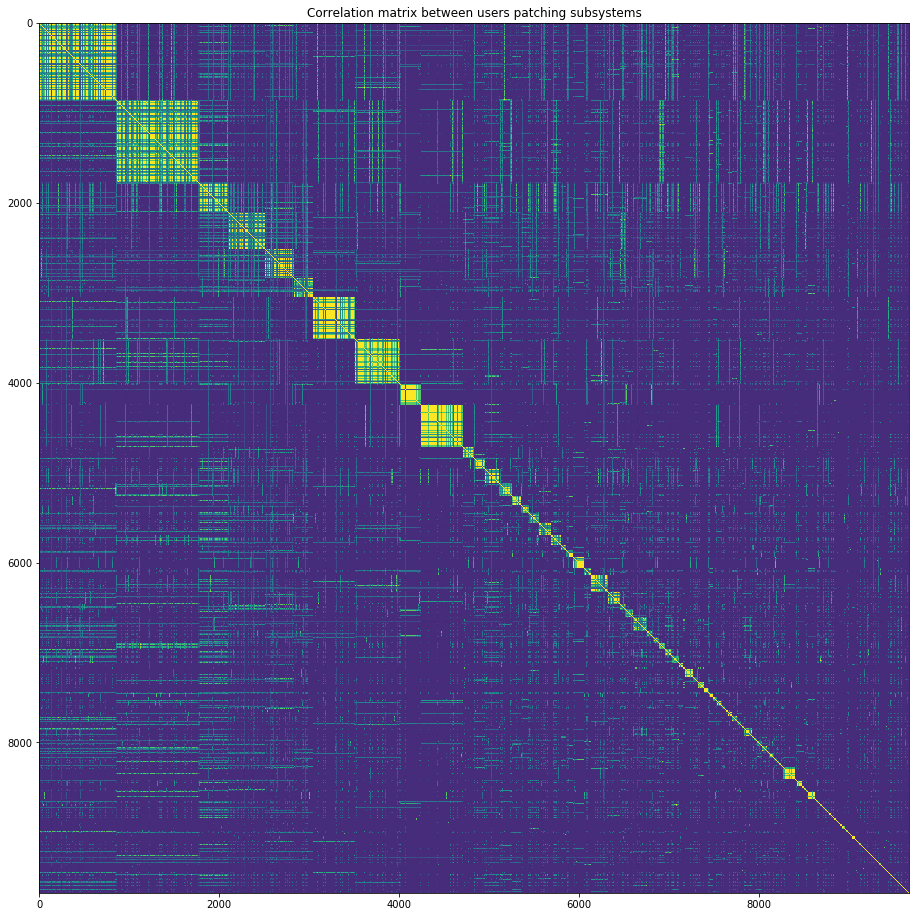

In [10]:
fig = plt.figure(figsize=(16, 16))
plt.imshow(C, cmap='viridis')
plt.title('Correlation matrix between users patching subsystems')
# Argument: [x, y, width, height]
# cax = plt.axes([0.9, 0.125, 0.01, 0.755])
# plt.colorbar(cax=cax)
plt.show()

### For the paper

In [11]:
sigconf_settings()

Sigconf settings loaded!


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


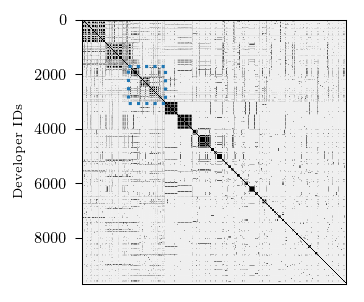

In [13]:
# C_binary = np.where(C > 0, [1], [0])

# Resize figure by factor
factor = 0.75

fig, ax = plt.subplots(1, figsize=(factor * 3.333, factor * 3.333))
# fig = plt.figure(figsize=(16, 16))
ax.imshow(C, cmap='Greys')

pos = 1700
size = 1350

ax.add_patch(
    patches.Rectangle(
        (pos, pos),   # (x,y)
        size,          # width
        size,          # height
        ls='dotted',
        fill=False,
        lw=1.5,
        color='C0'
    )
)

# plt.title('Correlation matrix between users patching subsystems')
# Argument: [x, y, width, height]
# cax = plt.axes([0.9, 0.125, 0.01, 0.755])
# plt.colorbar(cax=cax)
plt.xticks([], [])
plt.ylabel('Developer IDs', fontsize=6)
plt.savefig('../paper/fig/linux/correlation-matrix.pdf', dpi=300, bbox_inches='tight')